#OpenAI Gym CartPole Environment - Harish B
---
Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supoorts teaching agents everything from walking to playing games like Pong or Pinball.

###Reinforcement Learning Libraries uses Tensorflow as its Back-end:
1. Keras-RL
2. Tensorforce
3. TF agent
4. RLLib
5. TRFL
6. ReAgent
7. Garage
8. RLGraph
9. Dopamine


### Working Demo of CartPole Environment

In [ ]:
# Install gym with the following command
!pip install gym
!pip install pygame

#Rendering Dependencies
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
# Importing gym for the libraries
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
# Google Colab needs to render the environment to a virtual display we will record
# this as a video and play it after the training has finished.
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

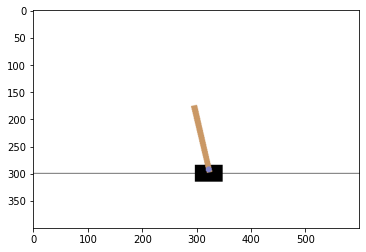

In [ ]:
# Creating instance of environment to play
env = gym.make("CartPole-v0")
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for _ in range(1000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  screen = env.render(mode='rgb_array')
  
  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())

  if done:
    break
    
ipythondisplay.clear_output(wait=True)
env.close()

In [ ]:
display.stop()

#OpenAI Gym CartPole Environment using TF-Agent

### Setup the following dependencies to run the project

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

/usr/local/lib/python3.7/dist-packages/tf_agents/typing/types.py:81: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Bool = Union[bool, np.bool, Tensor, Array]


### Hyper - Parameters

In [ ]:
num_iterations = 10000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 20  # @param {type:"integer"}
eval_interval = 200  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite. 

In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

The environment.step method takes an action in the environment and returns a TimeStep tuple containing the next observation of the environment and the reward for the action.

The time_step_spec() method returns the specification for the TimeStep tuple. Its observation attribute shows the shape of observations, the data types, and the ranges of allowed values. The reward attribute shows the same details for the reward.

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The action_spec() method returns the shape, data types, and allowed values of valid actions

In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats: 
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole 
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.01823224, -0.02447981,  0.00205765,  0.01658663], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.01774264,  0.17061257,  0.00238938, -0.2754464 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


Usually two environments are instantiated: one for training and one for evaluation. 

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN]

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [ ]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.

In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load('CartPole-v0'))

In [ ]:
time_step = example_environment.reset()

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=20):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

18.1

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.

In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [ ]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. 

In [ ]:
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'discount': array(1., dtype=float32),
  'observation': array([-0.03606885,  0.0258102 ,  0.08615673,  0.39119226], dtype=float32),
  'reward': array(1., dtype=float32),
  'step_type': array(1, dtype=int32)}), ())

The replay buffer is now a collection of Trajectories.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [ ]:
iterator = iter(dataset)
print(iterator)

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

In [ ]:
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 200: loss = 31.663925170898438
step = 200: Average Return = 28.399999618530273
step = 400: loss = 31.979537963867188
step = 400: Average Return = 84.9000015258789
step = 600: loss = 37.468048095703125
step = 600: Average Return = 46.650001525878906
step = 800: loss = 139.95867919921875
step = 800: Average Return = 30.5
step = 1000: loss = 20.227190017700195
step = 1000: Average Return = 81.30000305175781
step = 1200: loss = 49.13642120361328
step = 1200: Average Return = 105.25
step = 1400: loss = 22.902320861816406
step = 1400: Average Return = 176.10000610351562
step = 1600: loss = 7.005211353302002
step = 1600: Average Return = 31.049999237060547
step = 1800: loss = 115.63404083251953
step = 1800: Average Return = 69.94999694824219
step = 2000: loss = 175.017578125
step = 2000: Average Return = 148.8000030517578
step = 2200: loss = 127.03941345214844
step = 2200: Average Return = 200.0
step = 2400: loss = 548.578369140625
step = 2400: Average Return = 198.6999969482422
step =

## Visualization
### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-0.5500000000000007, 500.0)

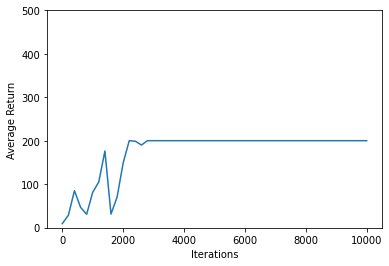

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=500)

### Videos 

(-0.5500000000000007, 250.0)

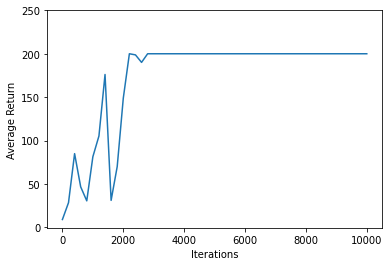

In [ ]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

#OpenAI Gym CartPole Environment using Keras RL

### Importing Libraries

- Keras rl2 : Integrates with the OpenAI Gym to evaluate and play around with DQN Algorithm
- Matplotlib: For displaying images and plotting model results.
- Keras: We use Keras, a high-level API to build and train deep learning models in TensorFlow.

In [ ]:
#Install keras rl2 which seamlessly integrates with the  OpenAI Gym  to evaluate and play around with DQN Algorithm
!pip install keras-rl2


#Install Open AI Gym for the Cart Pole Environment
!pip install gym

# Import the gym module
#Import Matplotlib to visualize the training steps
#Import the Keras modules for creating deep neural networks

import gym
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Input, Flatten, Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 748 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setting up the Cart Pole Environment with Open AI Gym
CartPole is one of the most simplest environments in OpenAI gym which is collection of environments to develop and test Reinforcement algorithms.

The goal of CartPole is to balance a pole connected with one joint on top of a moving cart. An agent can move the cart by performing a series of 0 or 1 actions, pushing it left or right.

1. Observation is an array of 4 floats which contains
  - Angular Position and Velocity of the Cart
  - Angular Position and Velocity of the Pole
2. Reward is a scalar float value
3. Action is a scalar integer with only two possible values:
  - 0 — "move left"
  - 1 — "move right"

In [ ]:
#Load the CartPole environment from the OpenAI Gym suite
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME)

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

##Building DQN Agent with Keras-RL

In [ ]:
import rl
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

# setup experience replay buffer
memory = SequentialMemory(limit=50000, window_length=1)

# setup the Linear annealed policy with the EpsGreedyQPolicy as the inner policy
policy =  LinearAnnealedPolicy(inner_policy=  EpsGreedyQPolicy(),   # policy used to select actions
                               attr='eps',                          # attribute in the inner policy to vary             
                               value_max=1.0,                       # maximum value of attribute that is varying
                               value_min=0.1,                       # minimum value of attribute that is varying
                               value_test=0.05,                     # test if the value selected is < 0.05
                               nb_steps=10000)                      # the number of steps between value_max and value_min

#Feed-Forward Neural Network Model for Deep Q Learning (DQN)
model = Sequential()
#Input is 1 observation vector, and the number of observations in that vector 
model.add(Input(shape=(1,env.observation_space.shape[0])))  
model.add(Flatten())
#Hidden layers with 24 nodes each
model.add(Dense(24, activation='relu'))
model.add(Dense(24, activation='relu'))
#Output is the number of actions in the action space
model.add(Dense(env.action_space.n, activation='linear'))

#Feed-Forward Neural Network Architecture Summary
print(model.summary())

#Defining DQN Agent for DQN Model
dqn = DQNAgent(model=model,                     # Q-Network model
               nb_actions=env.action_space.n,   # number of actions
               memory=memory,                   # experience replay memory
               nb_steps_warmup=25,              # how many steps are waited before starting experience replay
               target_model_update=1e-2,        # how often the target network is updated
               policy=policy)                   # the action selection policy

# Finally, we configure and compile our agent. 
#We can use built-in tensorflow.keras Adam optimizer and evaluation metrics            
from tensorflow.keras.optimizers import Adam
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae','accuracy'])

#Finally fit and train the agent
history = dqn.fit(env, nb_steps=50000, visualize=False, verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense_6 (Dense)             (None, 24)                120       
                                                                 
 dense_7 (Dense)             (None, 24)                600       
                                                                 
 dense_8 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
None
Training for 50000 steps ...
    15/50000: episode: 1, duration: 0.113s, episode steps:  15, steps per second: 132, episode reward: 15.000, mean reward:  1.000 [ 1.000,  1.000], mean 

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.7/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.7/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` 

    29/50000: episode: 2, duration: 0.556s, episode steps:  14, steps per second:  25, episode reward: 14.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.429 [0.000, 1.000],  loss: 0.517972, mae: 0.531151, accuracy: 0.687500, mean_q: 0.047039, mean_eps: 0.997570
    40/50000: episode: 3, duration: 0.090s, episode steps:  11, steps per second: 122, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.818 [0.000, 1.000],  loss: 0.507359, mae: 0.554000, accuracy: 0.536932, mean_q: 0.158918, mean_eps: 0.996940
    51/50000: episode: 4, duration: 0.090s, episode steps:  11, steps per second: 123, episode reward: 11.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.727 [0.000, 1.000],  loss: 0.450416, mae: 0.594284, accuracy: 0.465909, mean_q: 0.345890, mean_eps: 0.995950
    71/50000: episode: 5, duration: 0.159s, episode steps:  20, steps per second: 126, episode reward: 20.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.600 [0.000, 1.000

###Summary of Training episode steps and the total episodes of the DQN Model
One iteration of the Cartpole-v0 environment consists of 200-time steps.

The environment gives a reward of +1 for each step the pole stays up, so the maximum return for one episode is 200.

During its training, this instance of the DQN agent was able to achieve a maximum reward of 200 from 139th episodes to 199th episodes and from 277 to 376 episodes, meaning it reached 200 steps without dropping the pole with the least number of possible episodes while training.

From the graph, we can observe how in the first episodes, the rewards stay low as the agent is still exploring the state-space and learning the values for each state-action pair.

However, as we complete more episodes, the agent’s performance keeps improving and more episodes are completed.

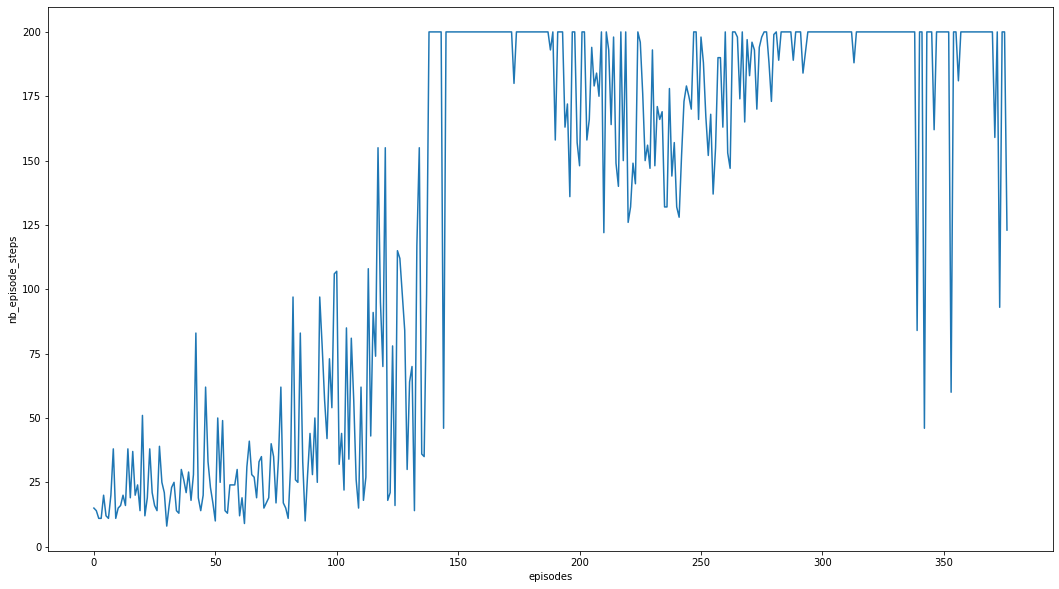

Testing for 20 episodes ...
Episode 1: reward: 200.000, steps: 200
Episode 2: reward: 200.000, steps: 200
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 200.000, steps: 200
Episode 6: reward: 200.000, steps: 200
Episode 7: reward: 200.000, steps: 200
Episode 8: reward: 200.000, steps: 200
Episode 9: reward: 200.000, steps: 200
Episode 10: reward: 200.000, steps: 200
Episode 11: reward: 200.000, steps: 200
Episode 12: reward: 200.000, steps: 200
Episode 13: reward: 200.000, steps: 200
Episode 14: reward: 200.000, steps: 200
Episode 15: reward: 200.000, steps: 200
Episode 16: reward: 200.000, steps: 200
Episode 17: reward: 200.000, steps: 200
Episode 18: reward: 200.000, steps: 200
Episode 19: reward: 200.000, steps: 200
Episode 20: reward: 200.000, steps: 200


In [ ]:
# Visualize the history for number of Training episode steps of the Cart Pole Game
plt.figure(figsize = (18,10))
plt.plot(history.history['nb_episode_steps'])
plt.ylabel('nb_episode_steps')
plt.xlabel('episodes')
plt.show()

# Finally, evaluate and test our algorithm for 20 episodes.
dqn.test(env, nb_episodes=20, visualize=False)

#Results & Discussion

- From the result predicted we can able to say that, TF agent performs well than Keras-RL.
- Keras-RL results 377 episodes and the maximum reward attain is 200 from 139th episodes to 199th episodes and from 277 to 376 episodes. 
- TF agent took 10000 steps and attain maximum reward 200, which shows its good performance because once it attains maximum, the reward doesn't dropped out.
- And for past few months there is no updates and maintanence from keras-rl to become the best frame work.
- This is the reason TF-agent is in good performace for the given Task.  